# <div align="center">SDP - Systèmes de décision</div>

### <div align="center">01-02-2025</div>

- Kiyoshi Araki

- GabrielSouza

- Lucas Tramonte


## Libraries

In [35]:
import numpy as np
import pandas as pd 
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
import random
%matplotlib inline
from gurobipy import *

## Data processing

In [36]:
number_of_bricks = 22
number_of_sr = 4

# Current Structure of Sales Territories :
sr_assignments_current = [(1, 4,  [4, 5, 6, 7, 8, 15]),
          (2, 14, [10, 11, 12, 13, 14]),
          (3, 16, [9, 16, 17, 18]),
          (4, 22, [1, 2, 3, 19, 20, 21, 22])    
         ]

In [37]:
bricks_index_values_file = "Assets/Data/bricks_index_values.csv"

# brick_workloads : dict[int : float] : associates a brick identifier j with its new index value v_j.
brick_workloads = dict()

# Loading data
with open(bricks_index_values_file) as bricksIndexValuesFile:
    reader = csv.DictReader(bricksIndexValuesFile)
    for row in reader:
        b = int(row['brick'])
        brick_workloads[b] = float(row['index_value'])
        
brick_rp_distances_file = "Assets/Data/brick_rp_distances.csv"

# distance_sr_brick : dict[(int, int) : float] : associates with the pair (i, j) of RP and brick identifiers, the distance separating i's office from the j brick
distance_sr_brick = dict()

# Loading data
with open(brick_rp_distances_file) as brickRpDistancesFile:
    reader = csv.DictReader(brickRpDistancesFile)
    for row in reader:
        b = int(row['brick'])
        for rpId in range(1, number_of_sr + 1):
            distance_sr_brick[(rpId, b)] = float(row[f'rp{rpId}'])

In [38]:
SR_set = set()
Center_Brick_Set = set()
Brick_List = list()

for rp, center_brick, bricks_assigned in sr_assignments_current:
    print(f'SR {rp}', f'Center Brick {center_brick}', f'Bricks assigned', *bricks_assigned)
    SR_set.add(rp)
    Center_Brick_Set.add(center_brick)
    Brick_List += bricks_assigned

Brick_List.sort()
assert Brick_List == list(range(1, number_of_bricks + 1))
assert Center_Brick_Set - set(Brick_List) == set()
assert SR_set == set(range(1, number_of_sr + 1))

SR 1 Center Brick 4 Bricks assigned 4 5 6 7 8 15
SR 2 Center Brick 14 Bricks assigned 10 11 12 13 14
SR 3 Center Brick 16 Bricks assigned 9 16 17 18
SR 4 Center Brick 22 Bricks assigned 1 2 3 19 20 21 22


In [39]:
assert brick_workloads[4] == 0.1516
assert brick_workloads[22] == 0.2531
assert distance_sr_brick[(1, 1)] == 16.16
assert distance_sr_brick[(2, 15)] == 2.32
assert distance_sr_brick[(3, 16)] == 0.00

# Step 1

## **Exercise**: 
Formulate and implement two mono-objective linear optimization models to solve the assignment problem using a distance and a disruption objective. Solve the instance with 22 Bricks and 4 Sales Representatives

Workload of each SR in the current solution for the new $v_j$ index values

In [40]:
SR = {} 
for j in range(0, number_of_sr):
    LinExpr = quicksum(brick_workloads[i] for i in sr_assignments_current[j][2]) 
    SR[f'SR{j+1}'] = round(LinExpr.getValue(),3)
    
SR_data = pd.DataFrame(list(SR.items()), columns=['i', 'Workload'])
SR_data

,i,Workload
0,SR1,0.951
1,SR2,1.338
2,SR3,0.705
3,SR4,1.007


In [41]:
# Define problem variables 

# -- Model initialization --
m = Model("rendu")

# Xij : dict[(int, int) : Var] : Assignment of brig j to SR office i
Xij = {(i, j) : m.addVar(vtype = GRB.BINARY, name=f'x_{i}_{j}') for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}

Constraints

- Each brick is assigned to a single SR

$$\sum_{i = 1}^{4} x_{ij} = 1 \;\;\;\; \text{for all $j = 1 \dots 22$} \;\;\;$$

In [42]:
CONSTR = {j : m.addConstr(quicksum(Xij[(i,j)] for i in range(1, number_of_sr + 1)) == 1, name = f'Constr{j}') for j in range(1, number_of_bricks + 1)}

- Each SR has a workload in the interval $[0.8, 1.2]$.

$$\sum_{j = 1}^{22} x_{ij}v_{j} \leq 1.2 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

$$\sum_{j = 1}^{22} x_{ij}v_{j} \geq 0.8 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

In [43]:
CHARGEINF = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) >= 0.8, name = f'Charge_inf{i}') for i in range(1, number_of_sr + 1)}
CHARGESUP = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) <= 1.2, name = f'Charge_sup{i}') for i in range(1, number_of_sr + 1)}

Define the objective of minimizing the total travel distance of all SRs.

$$\text{Minimize} \;\;\; \sum_{i = 1}^{4}\sum_{j = 1}^{22} x_{ij}d_{ij}$$

In [44]:
z1 = quicksum(Xij[(i,j)]*distance_sr_brick[(i,j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1))
# -- Objective function added --
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 0 # mute mode

# -- Model update --
m.update()
display(m)

<gurobi.Model MIP instance rendu: 30 constrs, 88 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [45]:
# -- Resolution --
m.optimize()

# Objective function value
print(f'z* = {round(m.objVal, 3)} km')

print('\n')

#Measure load and distance
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df

z* = 154.62 km




,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,2,14,"[11, 13, 14, 18]",1.045,7.56
2,3,16,"[10, 15, 16, 17]",1.115,6.56
3,4,22,"[1, 2, 3, 21, 22]",0.803,76.13


Define the objective function to minimize the weighted disturbance in percent (%).

$$\text{Minimize} \;\;\; 100\frac{\sum_{i = 1}^{4} \sum_{j = 1}^{22} x_{ij}v_j(1 - x_{ij}^*)}{\sum_{j = 1}^{22} v_j}$$

current assignment:
$$ x_{ij}^*  \;\;\; $$     

In [46]:
current_assignment = {(i, j) : 0 for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}
for SR, BSR_OFFICE, BRICKS in sr_assignments_current:
    value = 0
    for brick in BRICKS:
        current_assignment[(SR, brick)] = 1
        value += brick_workloads[brick]
        

z2 = 100 * quicksum([brick_workloads[j]*(1 - current_assignment[(i, j)])*Xij[(i, j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)]) / sum(brick_workloads.values())

print("The value of the weighted disturbance generated by the optimal solution is {} %.".format(round(z2.getValue(),3)))

The value of the weighted disturbance generated by the optimal solution is 30.138 %.


In [47]:
m.setObjective(z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

print(f' we obtain z* = {round(m.objVal, 3)} %  of the total disturbance ')

 we obtain z* = 4.24 %  of the total disturbance 


In [48]:
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df


,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
1,2,14,"[10, 13, 14]",1.168,7.79
2,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06
3,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74


In [49]:
print(df['Distance covered (km)'].sum(), 'km')

188.89 km


Reducing the weighted loss increases the total distance covered by the RP:

Minimization of total distance = (154.62, 30.138 )


Minimization of weighted disturbance = (188.89, 4.24)

### Implement the epsilon-constraint scheme to compute the set of all non-dominated solutions

$$\epsilon = 0.001$$

$$\alpha = 0$$

In [50]:
columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR OFFICE", "Bricks allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)


alpha = 0
epsilon = 0.001 

EpsilonDict = dict()

m.setObjective(z1 + alpha*z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = { 
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, SR_OFFICE, BRICKS in sr_assignments_current: 
        row["SR"] = SR
        row["SR OFFICE"] = SR_OFFICE
        row["Bricks allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\3034799165.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR OFFICE,Bricks allocated,Workload,Distance (km)
0,0,154.62,30.138,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,0,154.62,30.138,2,14,"[11, 13, 14, 18]",1.045,7.56
2,0,154.62,30.138,3,16,"[10, 15, 16, 17]",1.115,6.56
3,0,154.62,30.138,4,22,"[1, 2, 3, 21, 22]",0.803,76.13
4,1,154.64,28.068,1,4,"[4, 5, 6, 7, 8, 9, 19, 20]",0.955,42.38
...,...,...,...,...,...,...,...,...
75,18,188.13,5.675,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74
76,19,188.89,4.240,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
77,19,188.89,4.240,2,14,"[10, 13, 14]",1.168,7.79
78,19,188.89,4.240,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06


## Compute and represent the corresponding sets of non-dominated solutions for the 4x22 problem, with interval workload constraints [0.8, 1.2], [0.85, 1.15], and [0.9, 1.1],

In [51]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee)) # aggregating lists
Liste_solutions_efficaces = list(OrderedDict.fromkeys(solutions_efficaces)) # maintains the sequence in which keys are added
Liste_solutions_efficaces

[(154.62, 30.138),
 (154.64, 28.068),
 (154.99, 24.917),
 (160.58, 24.062),
 (160.71, 22.425),
 (163.35, 21.062),
 (164.57, 20.695),
 (164.64, 19.895),
 (165.9, 14.66),
 (166.44, 12.49),
 (167.21, 11.422),
 (168.14, 10.775),
 (168.9, 9.34),
 (172.93, 8.93),
 (173.86, 8.282),
 (174.62, 6.848),
 (183.17, 6.732),
 (187.2, 6.323),
 (188.13, 5.675),
 (188.89, 4.24)]

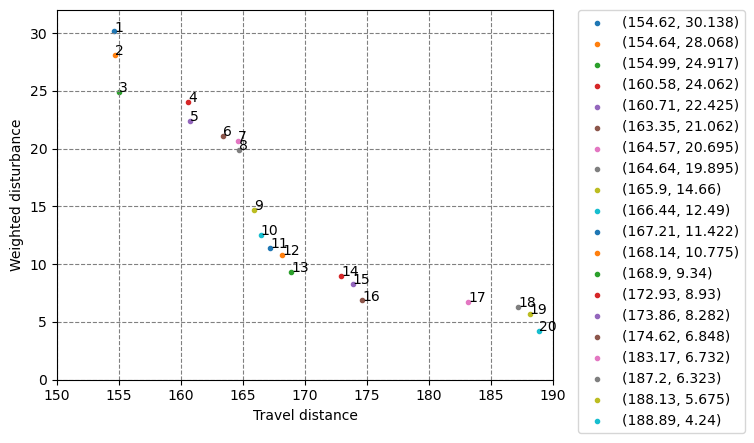

In [52]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

<font color="blue">
  <div align="center">There are exactly</div>
</font>

<div align="center">6 supported solutions.</div>
<div align="justify">These are 1, 2, 3, 13, 16, 20</div>

It is important to note that the old solution 13 was removed, but index 13 was reassigned to the next solution.  
To avoid confusion, the solution `(168.91, 9.707)` is not efficient and has not been included.  
The solution that moved from index 14 to index 13 is `(168.9, 9.34)`, and it is a supported solution.


Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.9, 1.1]$.

In [53]:
for cs in CHARGESUP.values():
    cs.RHS = 1.1
    
for ci in CHARGEINF.values():
    ci.RHS = 0.9

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\942549307.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,162.43,28.352,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,162.43,28.352,2,22,"[11, 13, 14, 17]",1.073,9.19
2,0,162.43,28.352,3,22,"[10, 15, 16, 18]",1.087,7.02
3,0,162.43,28.352,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
5,1,162.81,24.862,2,22,"[10, 14]",1.071,4.51
6,1,162.81,24.862,3,22,"[11, 13, 15, 16, 17, 18]",1.089,12.08
7,1,162.81,24.862,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,171.36,24.747,1,22,"[4, 5, 6, 7, 8, 9, 12, 20]",0.933,53.24
9,2,171.36,24.747,2,22,"[10, 14]",1.071,4.51


In [54]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(162.43, 28.352),
 (162.81, 24.862),
 (171.36, 24.747),
 (171.62, 12.168),
 (172.39, 11.1),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.66, 8.492),
 (187.18, 8.393),
 (187.2, 6.323)]

Represent these solutions in bi-criteria space.

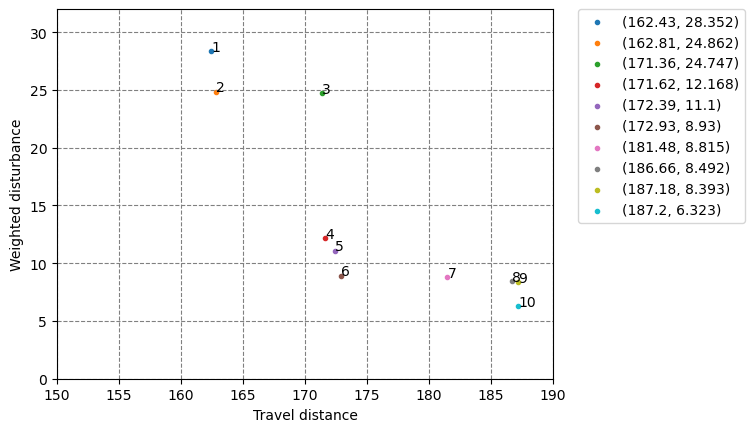

In [55]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.85, 1.15]$.

In [56]:
for cs in CHARGESUP.values():
    cs.RHS = 1.15
    
for ci in CHARGEINF.values():
    ci.RHS = 0.85

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\3950715657.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,160.34,27.645,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,160.34,27.645,2,22,"[11, 13, 14, 18]",1.045,7.56
2,0,160.34,27.645,3,22,"[10, 15, 16, 17]",1.115,6.56
3,0,160.34,27.645,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,160.36,25.575,1,22,"[4, 5, 6, 7, 8, 9, 19]",0.855,24.89
5,1,160.36,25.575,2,22,"[11, 12, 13, 14, 18]",1.127,29.57
6,1,160.36,25.575,3,22,"[10, 15, 16, 17]",1.115,6.56
7,1,160.36,25.575,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
9,2,162.81,24.862,2,22,"[10, 14]",1.071,4.51


In [57]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(160.34, 27.645),
 (160.36, 25.575),
 (162.81, 24.862),
 (169.11, 24.508),
 (171.6, 14.238),
 (171.62, 12.168),
 (172.14, 12.068),
 (172.16, 9.998),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.43, 7.39),
 (187.2, 6.323)]

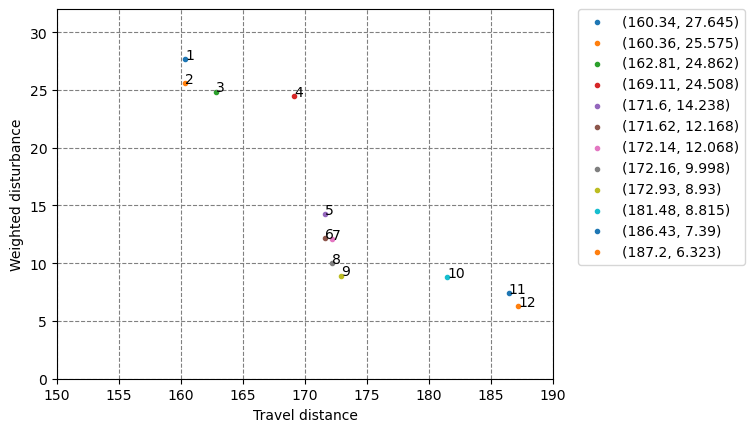

In [58]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

## Scaling up the model
With 10 SRs and 100 zones 

- Visual representation of the solution in the decision space




In [20]:
import pandas as pd

# We know each valid data row has 15 semicolon-delimited entries:
# 1) zone
# 2) x
# 3) y
# 4) workload_index
# 5) current_office
# 6..15) zone membership columns (z1..z10)
column_names = [
    "zone", "x", "y", "workload_index", "current_office",
    "z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8", "z9", "z10"
]

df = pd.read_csv(
    "Assets/Data/Pfitzer10-100.csv",
    skiprows=3,              # Skip the first 3 lines (including extra headers)
    names=column_names,      # Assign our known column names
    delimiter=";",           # Split columns on semicolons
    decimal=","              # Interpret commas as decimal points
)

# Convert columns to appropriate types
df["zone"] = df["zone"].astype(int)
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["workload_index"] = df["workload_index"].astype(float)
df["current_office"] = df["current_office"].astype(int)

# For the zone-membership columns (z1..z10), convert to integers
for zcol in column_names[5:]:
    df[zcol] = df[zcol].astype(int)

# (Optional) Add a unique brick identifier
df["brick_id"] = range(1, len(df) + 1)

# Now df contains the properly parsed data
print(df.head(10))


   zone       x       y  workload_index  current_office  z1  z2  z3  z4  z5  \
0     1  0.0137  0.0093          0.1602               0   1   0   0   0   0   
1     2  0.1292  0.0351          0.1266               0   1   0   0   0   0   
2     3  0.2587  0.0575          0.0011               1   1   0   0   0   0   
3     4  0.3334  0.0589          0.1515               0   1   0   0   0   0   
4     5  0.4490  0.0007          0.0318               0   0   1   0   0   0   
5     6  0.5410  0.0258          0.0081               0   0   1   0   0   0   
6     7  0.6560  0.0187          0.0739               0   0   1   0   0   0   
7     8  0.7898  0.0186          0.0683               0   0   1   0   0   0   
8     9  0.8902  0.0000          0.1562               0   0   1   0   0   0   
9    10  0.9984  0.0147          0.0536               0   0   1   0   0   0   

   z6  z7  z8  z9  z10  brick_id  
0   0   0   0   0    0         1  
1   0   0   0   0    0         2  
2   0   0   0   0    0   

##  2. Extracting the Current Assignment and Office Locations

In [24]:
# Create a dictionary for the current assignment:
# current_assignment[(i, j)] = 1 if brick j is currently assigned to SR i, else 0.
current_assignment = {}
SRs = range(1, 11)  # SR IDs 1 through 10

for _, row in df.iterrows():
    j = int(row["brick_id"])
    # For each SR i, check if the corresponding zone membership (z{i}) is 1.
    for sr in SRs:
        # The column name for SR 'sr' is "z{sr}"
        current_assignment[(sr, j)] = 1 if row[f"z{sr}"] == 1 else 0

# Determine each SR's office coordinates.
# For each SR, select the first brick that is flagged as a current office and is a member of that SR's zone.
sr_office = {}
for sr in SRs:
    office_rows = df[(df["current_office"] == 1) & (df[f"z{sr}"] == 1)]
    if not office_rows.empty:
        office_brick = office_rows.iloc[0]
        sr_office[sr] = (office_brick["x"], office_brick["y"])
    else:
        raise ValueError(f"No office found for SR {sr}.")

print("Office locations (SR: (x, y)):")
print(sr_office)


Office locations (SR: (x, y)):
{1: (0.2587, 0.0575), 2: (0.7665, 0.1071), 3: (0.9788, 0.2288), 4: (0.2208, 0.3531), 5: (0.8615, 0.5737), 6: (0.1276, 0.8978), 7: (0.2654, 0.7672), 8: (0.5478, 0.6742), 9: (0.8757, 0.7482), 10: (0.7729, 0.9541)}


# 3. Computing the Distance Matrix

In [25]:
import numpy as np

# Create a dictionary for distances d_{ij}
distance_sr_brick = {}
for sr in SRs:
    office_x, office_y = sr_office[sr]
    for _, row in df.iterrows():
        j = int(row["brick_id"])
        brick_x, brick_y = row["x"], row["y"]
        dist = np.sqrt((office_x - brick_x)**2 + (office_y - brick_y)**2)
        distance_sr_brick[(sr, j)] = dist


In [26]:
from gurobipy import Model, GRB, quicksum

# Create model
m = Model("Pfizer_assignment")

# Indices: bricks and SRs
bricks = df["brick_id"].tolist()  # Should be 1..100
# Decision variables: X[(i, j)] == 1 if brick j is assigned to SR i
X = {(i, j): m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}") 
     for i in SRs for j in bricks}

m.update()

# Constraint 1: Each brick is assigned exactly once
for j in bricks:
    m.addConstr(quicksum(X[(i, j)] for i in SRs) == 1, name=f"Assign_{j}")

# Constraint 2: Workload balance for each SR.
# Define lower and upper bounds. (Adjust these as appropriate.)
# For example, if workloads are normalized, you might use 0.8 and 1.2.
Lmin = 0.8
Lmax = 1.2
workload_index = {int(row["brick_id"]): row["workload_index"] for _, row in df.iterrows()}

for i in SRs:
    m.addConstr(
        quicksum(X[(i, j)] * workload_index[j] for j in bricks) >= Lmin,
        name=f"Load_min_{i}"
    )
    m.addConstr(
        quicksum(X[(i, j)] * workload_index[j] for j in bricks) <= Lmax,
        name=f"Load_max_{i}"
    )

# Define the objectives

# Objective 1: Total travel distance
z1 = quicksum(X[(i, j)] * distance_sr_brick[(i, j)] for i in SRs for j in bricks)

# Objective 2: Weighted disturbance.
total_workload = sum(workload_index.values())
z2 = 100 * quicksum(
    workload_index[j] * (1 - current_assignment[(i, j)]) * X[(i, j)]
    for i in SRs for j in bricks
) / total_workload

# For example, start with the travel distance objective.
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 1  # Set to 1 to see output if desired

m.update()
m.optimize()

print(f"Optimal total travel distance: {m.objVal:.3f}")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x178ce69f
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 59.7014641
Presolve time: 0.01s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Found heuristic solution: objective 49.0514060

Root relaxation: objective 1.480570e+01, 147 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

# Visualizing the Results

A. Plotting the Pareto Frontier

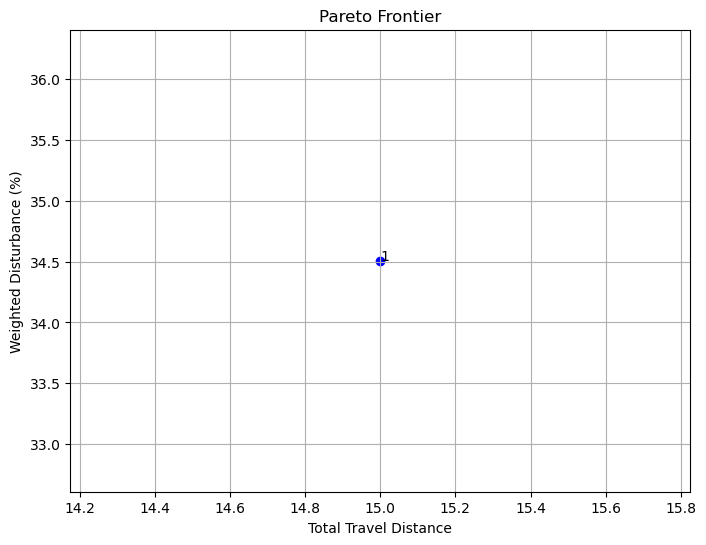

In [29]:
# Suppose these lists contain the objective values from multiple runs.
# (Here we use dummy data for illustration.)
Z1_values = [m.objVal]  # Replace with your collected travel distance values
Z2_values = [z2.getValue()]  # Replace with your collected disturbance values

plt.figure(figsize=(8, 6))
plt.scatter(Z1_values, Z2_values, c='blue', marker='o')
for idx, (d, dist) in enumerate(zip(Z1_values, Z2_values), start=1):
    plt.annotate(str(idx), (d, dist))
plt.xlabel("Total Travel Distance")
plt.ylabel("Weighted Disturbance (%)")
plt.title("Pareto Frontier")
plt.grid(True)
plt.show()


. Spatial Map of Brick Assignments

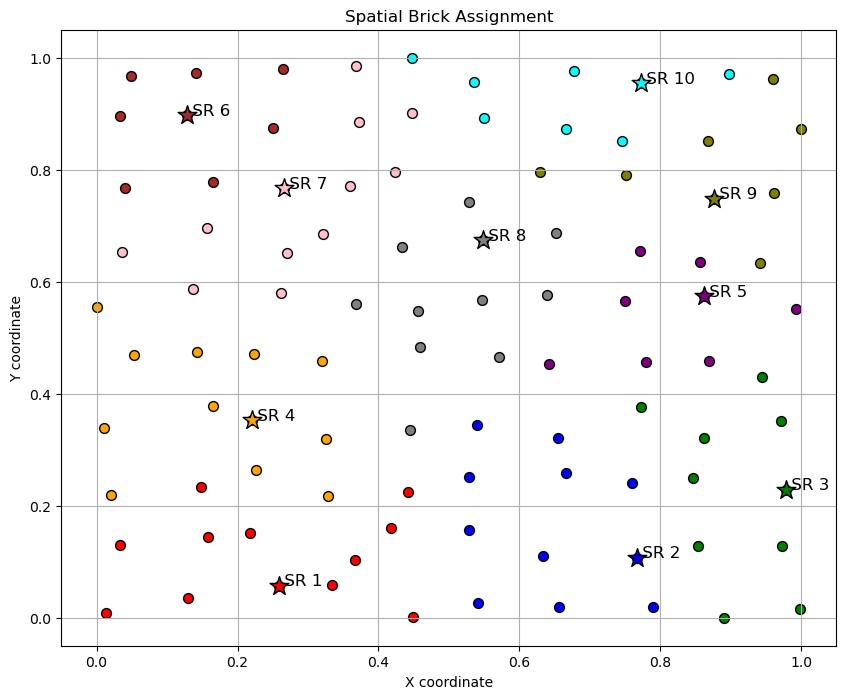

In [28]:
# Define colors for the 10 SRs (adjust or extend as needed)
colors = ['red', 'blue', 'green', 'orange', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(10, 8))

# Plot each brick colored by its assigned SR.
for _, row in df.iterrows():
    j = int(row["brick_id"])
    assigned_sr = None
    for i in SRs:
        if X[(i, j)].x > 0.5:  # Use a threshold since the variable is binary
            assigned_sr = i
            break
    plt.scatter(row["x"], row["y"],
                color=colors[assigned_sr - 1],
                s=50, edgecolor='k')

# Plot the office locations with a star marker.
for sr in SRs:
    office_x, office_y = sr_office[sr]
    plt.scatter(office_x, office_y,
                color=colors[sr - 1],
                marker='*', s=200, edgecolor='k')
    plt.text(office_x, office_y, f" SR {sr}", fontsize=12)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Spatial Brick Assignment")
plt.grid(True)
plt.show()


## Step 2

Compute and represent the corresponding sets of non-dominated solution

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x178ce69f
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]

Loaded MIP start from previous solve with objective 15.0001

Presolve time: 0.02s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 1.480570e+01, 147 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 

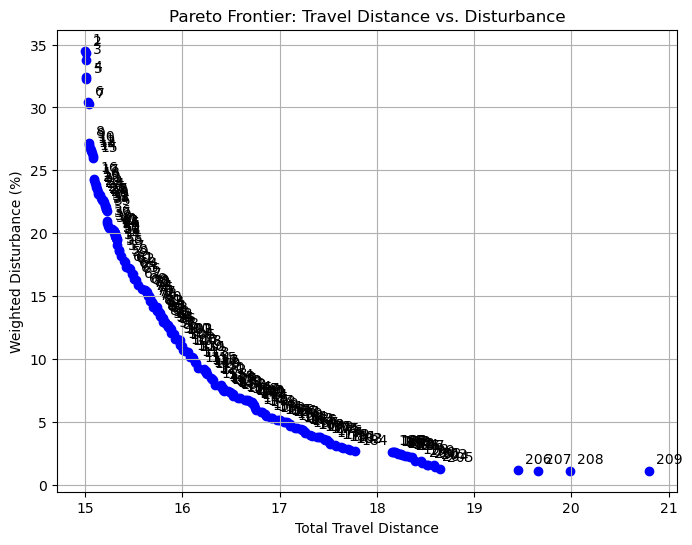

In [30]:
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# -------------
# (Re)build the model if not already built
# -------------
# Suppose the following have been defined:
# - SRs: a list or range(1, 11)
# - bricks: a list of brick IDs (1 to 100)
# - X: decision variables X[(i, j)] for i in SRs and j in bricks
# - distance_sr_brick: a dictionary mapping (i,j) -> distance
# - workload_index: a dictionary mapping brick j -> workload_index
# - total_workload: sum(workload_index.values())
# - current_assignment: dictionary {(i, j): 0 or 1} from the CSV data

# Define the objectives:
z1 = quicksum(X[(i, j)] * distance_sr_brick[(i, j)] for i in SRs for j in bricks)
z2 = 100 * quicksum(
    workload_index[j] * (1 - current_assignment[(i, j)]) * X[(i, j)]
    for i in SRs for j in bricks
) / total_workload

# -------------
# Setup the epsilon-constraint method:
# -------------
epsilon = 0.001   # a small decrement
pareto_solutions = []  # To record (z1, z2) values from each run
epsilon_constraints = {}  # To store added epsilon constraints (if needed for later removal)
iteration = 0

# We start by optimizing the travel distance objective:
m.setObjective(z1, GRB.MINIMIZE)
m.update()

# The iterative epsilon-constraint loop:
while True:
    m.optimize()
    if m.status == GRB.OPTIMAL:
        # Get the current solution's objective values.
        current_z1 = m.objVal
        current_z2 = z2.getValue()
        pareto_solutions.append((current_z1, current_z2))
        print(f"Iteration {iteration}: z1 = {current_z1:.3f}, z2 = {current_z2:.3f}")
        
        iteration += 1
        # Add an epsilon constraint to force a strictly lower weighted disturbance in the next run:
        constr_name = f"epsilon_{iteration}"
        epsilon_constraints[iteration] = m.addConstr(z2 <= current_z2 - epsilon, name=constr_name)
        m.update()
    else:
        # The model is infeasible; stop the loop.
        break

# Optionally, remove duplicate solutions (if any) while preserving order:
unique_solutions = list(dict.fromkeys(pareto_solutions))

# -------------
# Plotting the Pareto Frontier:
# -------------
Z1 = [sol[0] for sol in unique_solutions]
Z2 = [sol[1] for sol in unique_solutions]

plt.figure(figsize=(8, 6))
plt.scatter(Z1, Z2, color='blue', marker='o')
for idx, (d_val, disturbance) in enumerate(unique_solutions, start=1):
    plt.annotate(f"{idx}", (d_val, disturbance), textcoords="offset points", xytext=(5,5))
plt.xlabel("Total Travel Distance")
plt.ylabel("Weighted Disturbance (%)")
plt.title("Pareto Frontier: Travel Distance vs. Disturbance")
plt.grid(True)
plt.show()


How to model the case for partially assigning bricks

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# === Data Reading (using your corrected CSV reading) ===
column_names = [
    "zone", "x", "y", "workload_index", "current_office",
    "z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8", "z9", "z10"
]

df = pd.read_csv(
    "Assets/Data/Pfitzer10-100.csv",
    skiprows=3,              # Skip the first 3 lines (including extra headers)
    names=column_names,      # Assign our known column names
    delimiter=";",           # Split columns on semicolons
    decimal=","              # Interpret commas as decimal points
)

# Convert columns to appropriate types
df["zone"] = df["zone"].astype(int)
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["workload_index"] = df["workload_index"].astype(float)
df["current_office"] = df["current_office"].astype(int)
for zcol in column_names[5:]:
    df[zcol] = df[zcol].astype(int)
df["brick_id"] = range(1, len(df) + 1)

# === Build Current Assignment and Office Locations ===
SRs = range(1, 11)  # 10 sales representatives

# Current assignment: for each brick, determine for each SR if that brick is assigned
current_assignment = {}
for _, row in df.iterrows():
    j = int(row["brick_id"])
    for sr in SRs:
        current_assignment[(sr, j)] = 1 if row[f"z{sr}"] == 1 else 0

# Determine each SR's office location (first brick where current_office==1 and zone membership for that SR)
sr_office = {}
for sr in SRs:
    office_rows = df[(df["current_office"] == 1) & (df[f"z{sr}"] == 1)]
    if not office_rows.empty:
        office_brick = office_rows.iloc[0]
        sr_office[sr] = (office_brick["x"], office_brick["y"])
    else:
        raise ValueError(f"No office found for SR {sr}.")

# Compute the Euclidean distance from each SR's office to each brick
distance_sr_brick = {}
for sr in SRs:
    office_x, office_y = sr_office[sr]
    for _, row in df.iterrows():
        j = int(row["brick_id"])
        brick_x, brick_y = row["x"], row["y"]
        distance_sr_brick[(sr, j)] = np.sqrt((office_x - brick_x)**2 + (office_y - brick_y)**2)

# Workload index for each brick
workload_index = {int(row["brick_id"]): row["workload_index"] for _, row in df.iterrows()}
total_workload = sum(workload_index.values())

# === Build the Optimization Model with Partial Assignment ===
m_partial = Model("PartialAssignment")
# Decision variables: allow fractional assignment x_{ij} in [0,1]
# (Note: in the previous model these were binary.)
bricks = df["brick_id"].tolist()  # list of brick IDs from 1 to 100
X_partial = {(i, j): m_partial.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"x_{i}_{j}")
             for i in SRs for j in bricks}
m_partial.update()

# Constraint 1: Each brick's assignment fractions must sum to 1.
for j in bricks:
    m_partial.addConstr(quicksum(X_partial[(i, j)] for i in SRs) == 1, name=f"Assign_{j}")

# Constraint 2: Workload balance for each SR.
# (Using the same bounds as before; these can be adjusted.)
Lmin = 0.8
Lmax = 1.2
for i in SRs:
    m_partial.addConstr(
        quicksum(X_partial[(i, j)] * workload_index[j] for j in bricks) >= Lmin,
        name=f"Load_min_{i}"
    )
    m_partial.addConstr(
        quicksum(X_partial[(i, j)] * workload_index[j] for j in bricks) <= Lmax,
        name=f"Load_max_{i}"
    )

# Define the objectives (same as before)
z1_partial = quicksum(X_partial[(i, j)] * distance_sr_brick[(i, j)] for i in SRs for j in bricks)
z2_partial = 100 * quicksum(
    workload_index[j] * (1 - current_assignment[(i, j)]) * X_partial[(i, j)]
    for i in SRs for j in bricks
) / total_workload

# For demonstration, we start by minimizing travel distance.
m_partial.setObjective(z1_partial, GRB.MINIMIZE)
m_partial.params.outputflag = 1  # show solver output
m_partial.update()

m_partial.optimize()

print("----- Partial Assignment Model Results -----")
print(f"Optimal total travel distance: {m_partial.objVal:.3f}")
print(f"Corresponding weighted disturbance: {z2_partial.getValue():.3f} %")

# For comparison, you could retrieve and print the objective values of your previous (binary) model,
# which we assume were stored in variables like `m_binary_objVal` and `z2_binary`.
# (Here, we simply print the partial assignment solution values.)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x308d24c5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Presolve removed 10 rows and 0 columns
Presolve time: 0.01s
Presolved: 110 rows, 1010 columns, 2010 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4287623e+01   3.567100e+00   0.000000e+00      0s
      19    1.4805696e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.480569572e+01
----- Partial Assignment Model Results -----
Optimal total travel distance: 14.806
Corresponding weight

Visualizing the results

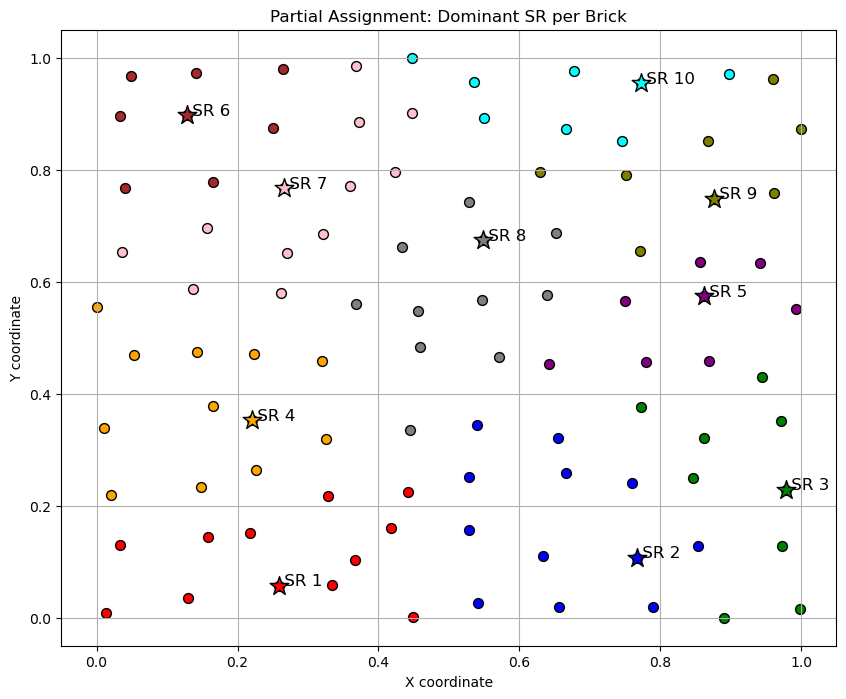

In [32]:
# Determine for each brick the SR with the highest assigned fraction in the partial model.
assigned_sr_partial = {}
for j in bricks:
    max_val = 0
    best_sr = None
    for i in SRs:
        val = X_partial[(i, j)].x
        if val > max_val:
            max_val = val
            best_sr = i
    assigned_sr_partial[j] = best_sr

colors = ['red', 'blue', 'green', 'orange', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(10, 8))
for _, row in df.iterrows():
    j = int(row["brick_id"])
    sr = assigned_sr_partial[j]
    plt.scatter(row["x"], row["y"], color=colors[sr - 1], s=50, edgecolor='k')
    
# Also plot the office locations
for sr in SRs:
    office_x, office_y = sr_office[sr]
    plt.scatter(office_x, office_y, color=colors[sr - 1],
                marker='*', s=200, edgecolor='k')
    plt.text(office_x, office_y, f" SR {sr}", fontsize=12)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Partial Assignment: Dominant SR per Brick")
plt.grid(True)
plt.show()


If the demand increases uniformly in all bricks

Increase Demand and Prepare the Data

In [33]:
# Increase the workload by 25% for each brick
workload_index_new = {j: 1.25 * row["workload_index"]
                      for j, row in df.set_index("brick_id").iterrows()}
total_workload_new = sum(workload_index_new.values())


Loop Over Candidate Office Locations for the New SR

In [35]:
import math
from gurobipy import Model, GRB, quicksum

# Workload bounds (you may keep them as before; here we assume the same numeric bounds)
Lmin = 0.8
Lmax = 1.2

# Original SRs (1 to 10) have fixed office locations in sr_office (assumed computed earlier)
# List of all brick IDs
bricks = df["brick_id"].tolist()

# To store candidate results: (candidate brick id, x, y, objective value)
candidate_results = []

best_obj = float('inf')
best_candidate = None

# Loop over candidate bricks for the new SR's office
for candidate in bricks:
    # Get candidate coordinates from df
    candidate_row = df.loc[df["brick_id"] == candidate].iloc[0]
    candidate_x = candidate_row["x"]
    candidate_y = candidate_row["y"]
    
    # Build new SR office dictionary for 11 SRs:
    sr_office_new = sr_office.copy()  # original 10 SRs (fixed)
    sr_office_new[11] = (candidate_x, candidate_y)  # new candidate for SR 11
    
    # Build the assignment model for 11 SRs.
    m_new = Model("Assignment_with_new_SR")
    SRs_new = list(range(1, 12))  # 1 to 11
    # Decision variables: binary variables x_{ij} (brick j assigned to SR i)
    X_new = {(i, j): m_new.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
             for i in SRs_new for j in bricks}
    m_new.update()
    
    # Constraint: each brick must be assigned exactly once.
    for j in bricks:
        m_new.addConstr(quicksum(X_new[(i, j)] for i in SRs_new) == 1, name=f"Assign_{j}")
    
    # Workload balance for each SR using the increased workloads:
    for i in SRs_new:
        m_new.addConstr(
            quicksum(X_new[(i, j)] * workload_index_new[j] for j in bricks) >= Lmin,
            name=f"Load_min_{i}"
        )
        m_new.addConstr(
            quicksum(X_new[(i, j)] * workload_index_new[j] for j in bricks) <= Lmax,
            name=f"Load_max_{i}"
        )
    
    # Compute the distance from each SR’s office to each brick.
    distance_new = {}
    for i in SRs_new:
        office_x, office_y = sr_office_new[i]
        for j in bricks:
            # Retrieve brick coordinates
            row = df.loc[df["brick_id"] == j].iloc[0]
            brick_x, brick_y = row["x"], row["y"]
            distance_new[(i, j)] = math.sqrt((office_x - brick_x)**2 + (office_y - brick_y)**2)
    
    # Define the objective: total travel distance over all assignments.
    z1_new = quicksum(X_new[(i, j)] * distance_new[(i, j)] for i in SRs_new for j in bricks)
    m_new.setObjective(z1_new, GRB.MINIMIZE)
    m_new.params.outputflag = 0  # set to 1 to display solver output
    m_new.update()
    
    m_new.optimize()
    
    if m_new.status == GRB.OPTIMAL:
        obj_val = m_new.objVal
        candidate_results.append((candidate, candidate_x, candidate_y, obj_val))
        if obj_val < best_obj:
            best_obj = obj_val
            best_candidate = candidate
    else:
        candidate_results.append((candidate, candidate_x, candidate_y, None))
    
# Display the best candidate
print("Best candidate for new office (brick id):", best_candidate)
best_coords = df.loc[df["brick_id"]==best_candidate, ["x", "y"]].values[0]
print("Coordinates of best candidate:", best_coords)
print("Objective value (total travel distance):", best_obj)


Best candidate for new office (brick id): 25
Coordinates of best candidate: [0.4423 0.2249]
Objective value (total travel distance): 14.240074566198011


Compare and Visualize

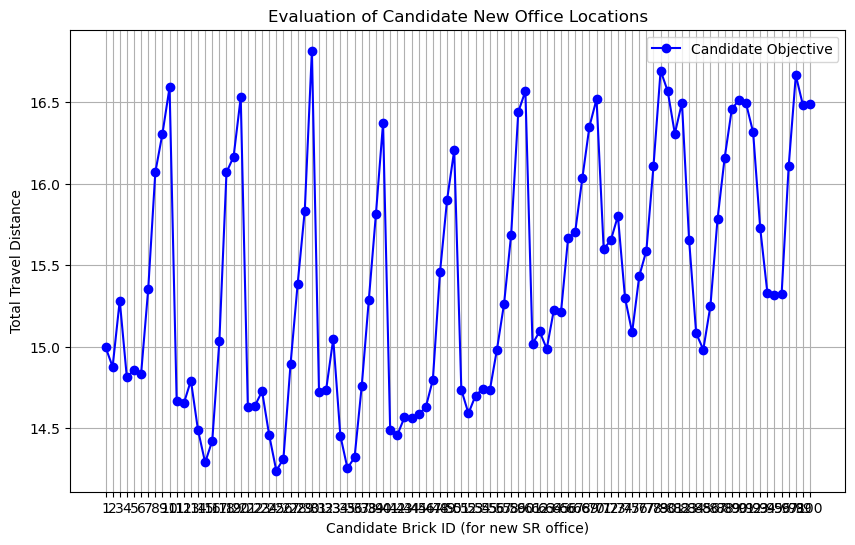

In [37]:
import matplotlib.pyplot as plt

# Extract candidate data for plotting (only candidates with feasible solutions)
candidates = [str(r[0]) for r in candidate_results if r[3] is not None]
obj_vals = [r[3] for r in candidate_results if r[3] is not None]

plt.figure(figsize=(10, 6))
plt.plot(candidates, obj_vals, 'bo-', label="Candidate Objective")
plt.xlabel("Candidate Brick ID (for new SR office)")
plt.ylabel("Total Travel Distance")
plt.title("Evaluation of Candidate New Office Locations")
plt.grid(True)
plt.legend()
plt.show()
